# Connecting

In [17]:
import os
import numpy as np

# setting working dir
os.chdir("../src")

In [18]:
from elasticsearch_db.elasticsearch import elastic_conection
from elasticsearch_db.elasticsearch import get_nlp_model

es = elastic_conection()

In [19]:
workspace_id = "dc1e7b3d-9137-4a20-a99c-d0d2029ef170"
workspace, exist = get_nlp_model(es, workspace_id=workspace_id)
exist

True

# Data Sourcing

In [20]:
from data_pipeline.data_sourcing import get_data

#get_data?

In [21]:
df = get_data(workspace=workspace, es=es)
df.head()

,intents,examples
0,Inativar_Posição,Como realizo a inativação de uma posição de mi...
1,Inativar_Posição,Como realizo a reativação de uma posição em mi...
2,Inativar_Posição,Em quanto tempo a inativação de uma posição é ...
3,Inativar_Posição,"Gostaria de fazer a inativação de uma posição,..."
4,Inativar_Posição,Realizei a inativação de uma posição e ela con...


# Data Preprocessing

### Create artificial Examples

In [6]:
# from data_pipeline.data_preprocessing import fill_missing_examples

# fill_missing_examples?

In [7]:
# data = fill_missing_examples(data)

### Cleansing

In [22]:
from data_pipeline.data_preprocessing import clean_examples

#clean_examples?

In [23]:
df = clean_examples(df)

In [24]:
df.head()

,intents,examples,cleaned_examples
0,Inativar_Posição,Como realizo a inativação de uma posição de mi...,realiz inativ pos estrut
1,Inativar_Posição,Como realizo a reativação de uma posição em mi...,realiz reativ pos estrut
2,Inativar_Posição,Em quanto tempo a inativação de uma posição é ...,quant temp inativ pos efetiv
3,Inativar_Posição,"Gostaria de fazer a inativação de uma posição,...",gost faz inativ pos fac
4,Inativar_Posição,Realizei a inativação de uma posição e ela con...,realiz inativ pos continu vis


# Feature Extracting

In [25]:
from data_pipeline.feature_extracting import encode_features

df, x_transformer, y_transformer = encode_features(df)
df.head(2)

,intents,examples,cleaned_examples,intents_onehot,13o,1a,2808sem,2k,2o,abaix,...,vou,vr,vtnc,word,workflow,wwwpremiertravelc,xau,yar,yarin,zacarin
0,Inativar_Posição,Como realizo a inativação de uma posição de mi...,realiz inativ pos estrut,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Inativar_Posição,Como realizo a reativação de uma posição em mi...,realiz reativ pos estrut,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Splitting

In [26]:
from data_pipeline.data_splitting import split

In [27]:
X_train, X_test, y_train, y_test = split(df)

In [28]:
X_train.shape

(817, 1174)

In [29]:
X_test.shape

(403, 1174)

In [30]:
y_train.shape

(817, 2)

In [31]:
y_test.shape

(403, 2)

In [32]:
y_test.head()

,intents,intents_onehot
405,Detalhe_Sobre_Desconto,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1071,Transferir_Colaborador_Filial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
429,Direito_ao_13,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1171,Verificar_Historico_Previdencia,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
779,Hora_Extra,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [34]:
y_test.intents.nunique()

190

In [35]:
y_train.intents.nunique()

190

# Training

#### Logistic Regression

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

def train_logreg(X, y, **hyper_parameters):
    model = LogisticRegression(
                    n_jobs=-1,
                    **hyper_parameters
            )
        

    model.fit(X, y.intents)
    return model

In [84]:
hyper_parameters = {
                "multi_class": "multinomial",
                "fit_intercept": False,
                "C": 5,
                "random_state": 42,
                "max_iter": 1000}

In [85]:
logreg_clf = train_logreg(
                    X=X_train, 
                    y=y_train,
                    **hyper_parameters
            )

In [86]:
y_pred = logreg_clf.predict(X_test)
np.sum(y_pred == y_test.intents) / y_test.shape[0]

0.5558312655086849

In [87]:
logreg_clf.predict_proba([X_test.iloc[0]])

array([[0.00382202, 0.00376217, 0.00387697, 0.00434802, 0.00378701,
        0.0203652 , 0.00386112, 0.00377277, 0.00379206, 0.00383809,
        0.00382853, 0.00379151, 0.00388488, 0.00384033, 0.00376115,
        0.00519271, 0.00386738, 0.0038066 , 0.00366764, 0.00382163,
        0.00381047, 0.00376541, 0.00382149, 0.00379371, 0.00385451,
        0.00375297, 0.00385807, 0.00486169, 0.00384127, 0.00386689,
        0.00383927, 0.00382324, 0.00381353, 0.00383143, 0.00340203,
        0.00379665, 0.00382706, 0.00382519, 0.00997034, 0.00378374,
        0.00379642, 0.00371985, 0.00440795, 0.00376949, 0.00379666,
        0.0052829 , 0.00379539, 0.00383139, 0.00385898, 0.00380309,
        0.010825  , 0.00381768, 0.0038315 , 0.00375465, 0.00495597,
        0.00386907, 0.00383727, 0.00380407, 0.00388131, 0.00385049,
        0.00567158, 0.00382539, 0.00421234, 0.00384935, 0.00381869,
        0.00799066, 0.00988192, 0.00647337, 0.04390462, 0.00383904,
        0.00386376, 0.00383673, 0.00386777, 0.00

#### SVM

In [88]:
from sklearn import svm

def train_svm(X, y, **hyper_parameters):
    model = svm.SVC(
                    probability=True,
                    **hyper_parameters
              )
        
    model.fit(X, y.intents)
    return model

In [89]:
hyper_parameters = {
          "kernel": "poly", 
          "degree": 1,
          "coef0": 0,
          "random_state": 42
        }
svm_clf = train_svm(
                X=X_train, 
                y=y_train,
                **hyper_parameters
            )

In [90]:
y_pred = svm_clf.predict(X_test)
np.sum((y_pred == y_test.intents)) / y_test.shape[0]

0.4838709677419355

In [91]:
svm_clf.predict_proba([X_test.iloc[0]])

array([[0.00306106, 0.00641751, 0.00408806, 0.00452781, 0.00490817,
        0.00694625, 0.0021326 , 0.0023639 , 0.00467333, 0.00193648,
        0.00478029, 0.00496637, 0.00296317, 0.00322381, 0.00436512,
        0.01044907, 0.00268255, 0.00603941, 0.00993999, 0.00222272,
        0.00314836, 0.00394817, 0.0055226 , 0.00359113, 0.00241712,
        0.00401117, 0.00192506, 0.00458564, 0.00408386, 0.00290265,
        0.00210494, 0.00492424, 0.00450757, 0.00299924, 0.00204994,
        0.00425702, 0.00679804, 0.00206433, 0.01587772, 0.00464743,
        0.00492184, 0.00543427, 0.0031828 , 0.00294165, 0.00319342,
        0.01034369, 0.0048632 , 0.00204229, 0.00405178, 0.00316612,
        0.00836922, 0.00354562, 0.00245942, 0.00593224, 0.00348146,
        0.00248887, 0.00316653, 0.00433585, 0.00334471, 0.00264401,
        0.00331257, 0.00271333, 0.00857719, 0.00543311, 0.00447885,
        0.013201  , 0.00522042, 0.00940554, 0.0219233 , 0.00422381,
        0.00459447, 0.00260931, 0.00251267, 0.00

#### Neural Network

In [92]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.compose import TransformedTargetRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd


learning_rate = 0.001
loss = "categorical_crossentropy"
number_of_intent_classes = df.intents.nunique()
n_features = X_train.shape[1]
input_shape = (n_features,)

# Keras Model
def build_nn():
    model = Sequential()
    model.add(
            Dense(
                units=input_shape[0],
                activation="relu",
                input_shape=input_shape,
                name="input_layer",
            )
    )
    model.add(Dense(units=input_shape[0], activation="relu", name="layer_2"))
    # Output
    model.add(
        Dense(units=number_of_intent_classes, activation="softmax", name="output_layer")
    )

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=["accuracy"]
    )
    return model


def train_nn(X, y, **hyper_parameters):
    model = build_nn()
    X = X.to_numpy()
    y = np.array(y.intents_onehot.tolist())
    history = model.fit(
                    X,
                    y,
                    **hyper_parameters
              )
    
    return model, history

In [93]:
import pandas as pd

hyper_parameters = {
  "epochs": 10,
  "verbose":True,
  "batch_size": 100,
  "validation_split":0.2
}


nn_clf, history = train_nn(
                X=X_train, 
                y=y_train,
                **hyper_parameters
          )

Epoch 1/10
7/7 [==============================] - 2s 152ms/step - loss: 5.2390 - accuracy: 0.0224 - val_loss: 5.2240 - val_accuracy: 0.0488
Epoch 2/10
7/7 [==============================] - 0s 48ms/step - loss: 5.0581 - accuracy: 0.1867 - val_loss: 5.2006 - val_accuracy: 0.0305
Epoch 3/10
7/7 [==============================] - 0s 44ms/step - loss: 4.7568 - accuracy: 0.1111 - val_loss: 5.2798 - val_accuracy: 0.0427
Epoch 4/10
7/7 [==============================] - 0s 47ms/step - loss: 4.4011 - accuracy: 0.1628 - val_loss: 5.2080 - val_accuracy: 0.0793
Epoch 5/10
7/7 [==============================] - 1s 110ms/step - loss: 3.9406 - accuracy: 0.3851 - val_loss: 4.9596 - val_accuracy: 0.1037
Epoch 6/10
7/7 [==============================] - 0s 47ms/step - loss: 3.3119 - accuracy: 0.5525 - val_loss: 4.6900 - val_accuracy: 0.1220
Epoch 7/10
7/7 [==============================] - 0s 45ms/step - loss: 2.5280 - accuracy: 0.6801 - val_loss: 4.3623 - val_accuracy: 0.1951
Epoch 8/10
7/7 [=========

In [94]:
y_pred = nn_clf.predict_classes(X_test.to_numpy());
y_test_argmax = np.array([np.argmax(v) for v in y_test.intents_onehot.tolist()])
np.sum((y_pred == y_test_argmax)) / y_test.shape[0]

/usr/local/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.5210918114143921

# Train ensemble

#### Voting

In [63]:
from sklearn.ensemble import VotingClassifier

def train_voting(X_train, y_train, estimators, weights, **kwargs):
    meta_model = VotingClassifier(
                        estimators=estimators,
                        weights=weights,
                        **kwargs)
#     model = TransformedTargetRegressor(
#                                 regressor=meta_model,
#                                 transformer=IndexLabelEncode(y=y)
#             )
    meta_model.fit(X_train, y_train)
    return meta_model


estimators = [('clf1', logreg_clf), 
              ('clf2', svm_clf),
              ('clf3', nn_clf)]
weights = [0.6929982046678635, 0.6427289048473968, 0.6894075274467468]
voting = train_voting(train.example_text, train.intent_name, 
                      estimators, 
                      weights,
                      voting='soft',
                      flatten_transform=True,
                      n_jobs=-1)
y_pred = voting.predict(X_test)
accuracy = np.sum((y_pred == y_test).all(1)) / y_test.shape[0]
accuracy

NameError: name 'train' is not defined

# Prefect

In [1]:
import os

# setting working dir
os.chdir("../src")

from prefect import Flow, task, context

from data_pipeline.data_sourcing import get_data
from data_pipeline.data_preprocessing import fill_missing_examples, clean_examples
from data_pipeline.feature_engineering import intents_to_onehot, create_corpus, encode_features
from data_pipeline.data_splitting import data_splitting
from elasticsearch_db.elasticsearch import elastic_conection
from elasticsearch_db.elasticsearch import get_nlp_model

es = elastic_conection()
workspace_id = "dc1e7b3d-9137-4a20-a99c-d0d2029ef170"
workspace, exist = get_nlp_model(es, workspace_id=workspace_id)
exist

True

In [2]:
@task
def sourcing(workspace, es):

    return get_data(
                workspace=workspace, 
                es=es
            )

@task
def imputation(data):
    
    return fill_missing_examples(data)

@task
def cleansing(data):

    return clean_examples(data)

@task(nout=2)
def splitting(data):

    return data_splitting(data)

@task(nout=4)
def encoding(train, test):
    all_intents = set([example[0] for example in train])
    map_onehot, intent_dictionary = intents_to_onehot(
                                        intents_name=all_intents
                                    )
    all_examples = [example[0] for example in train] + \
                   [example[0] for example in test]
        
    corpus = create_corpus(examples_text=all_examples)
    
    X_train, y_train, X_test, y_test = encode_features(
                                            train=train, 
                                            test=test, 
                                            corpus=corpus, 
                                            map_onehot=map_onehot
                                    )
    return X_train, y_train, X_test, y_test

In [3]:
# Define prefect flow
with Flow("train_dataflow") as flow:

    data = sourcing(workspace=workspace, es=es)
    data = imputation(data=data)
    data = cleansing(data=data)
    train, test = splitting(data=data)
    X_train, y_train, X_test, y_test = encoding(train=train, 
                                                test=test)

[2021-04-21 12:08:00+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'train_dataflow'
[2021-04-21 12:08:01+0000] INFO - prefect.TaskRunner | Task 'sourcing': Starting task run...
[2021-04-21 12:08:01+0000] INFO - prefect.TaskRunner | Task 'sourcing': Finished task run for task with final state: 'Success'
[2021-04-21 12:08:01+0000] INFO - prefect.TaskRunner | Task 'imputation': Starting task run...
[2021-04-21 12:08:21+0000] INFO - prefect.TaskRunner | Task 'imputation': Finished task run for task with final state: 'Success'
[2021-04-21 12:08:21+0000] INFO - prefect.TaskRunner | Task 'cleansing': Starting task run...
[2021-04-21 12:08:22+0000] INFO - prefect.TaskRunner | Task 'cleansing': Finished task run for task with final state: 'Success'
[2021-04-21 12:08:22+0000] INFO - prefect.TaskRunner | Task 'splitting': Starting task run...
[2021-04-21 12:08:22+0000] INFO - prefect.TaskRunner | Task 'splitting': Finished task run for task with final state: 'Success'
[2021-04-21 12:08

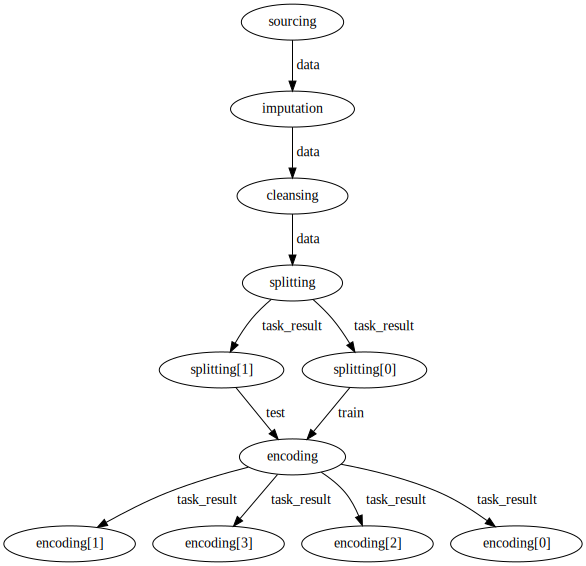

In [4]:
# Run prefect flow
flow.run()

# Export flow as a PDF
flow.visualize(filename="../src/data_pipeline/flow_diagrams/train_dataflow")